# CS182 PointNet Homework

<div style="text-align: center;">
  <table style="display: inline-table; font-size: 18px; border-collapse: collapse;">
    <tr>
      <td style="padding: 10px; border: 1px solid black;">Artem Tkachuk</td>
      <td style="padding: 10px; border: 1px solid black;">Ethan Shedd</td>
      <td style="padding: 10px; border: 1px solid black;">Nicolas Eichenberger</td>
    </tr>
    <tr>
      <td style="padding: 10px; border: 1px solid black;">aat@berkeley.edu</td>
      <td style="padding: 10px; border: 1px solid black;">shedd@berkeley.edu</td>
      <td style="padding: 10px; border: 1px solid black;">neichen@berkeley.edu</td>
    </tr>
  </table>
</div>

## Question 4: train a PointNet to do segmentation

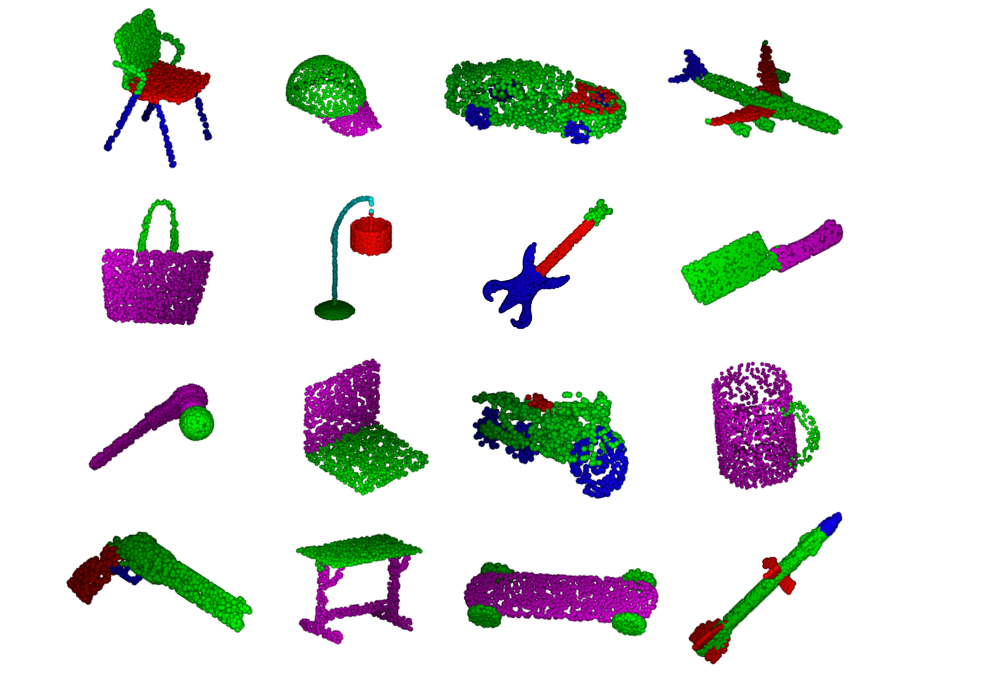

# 1. Setup

## TODO don't forget to change runtime type to GPU!!!
Otherwise you are condemning yourself to ages of training....... jk, but it'll be slower

<img src="https://drive.google.com/uc?export=view&id=1Kl3eF9ULHrIz1_CT8qKRe4jZ9bAtt893" width="500" align="left"> <img src="https://drive.google.com/uc?export=view&id=1K4XdAdTu3yoJcL15tw_BETxz-GYAWZhn" width="500" align="left">

In [ ]:
!pip install torch
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', 'You did not enable GPU! Please enable it before continuing!'

## Download repo

In [ ]:
!git clone https://github.com/artem-tkachuk/cs182-project-pointnet.git cs182_project_pointnet

In [4]:
# Don't think about it too much and just execute this :) it's a small patch
!mkdir /content/cs182_project_pointnet/misc
!touch /content/cs182_project_pointnet/misc/num_seg_classes.txt

## Install packages

In [ ]:
!pip install torch tqdm numpy plyfile ipympl scikit-learn gdown

## Import packages

In [6]:
from __future__ import print_function
import torch.utils.data as data
import os
import os.path
import torch
import numpy as np
import sys
from tqdm import tqdm 
import json
from plyfile import PlyData, PlyElement
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import argparse
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import warnings
from google.colab import output
from mpl_toolkits.mplot3d import axes3d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Autoreload

Set autoreload to 2 sec so that your changes to the files in the repo update in notebook

In [7]:
%load_ext autoreload
%autoreload 2

## Download dataset

**Dataset citation:**

*Chang, Angel X. and Funkhouser, Thomas and Guibas, Leonidas and Hanrahan, Pat and Huang, Qixing and Li, Zimo and Savarese, Silvio and Savva, Manolis and Song, Shuran and Su, Hao and Xiao, Jianxiong and Yi, Li and Yu, Fisher (2015).* 

*ShapeNet: An Information-Rich 3D Model Repository. Stanford University --- Princeton University --- Toyota Technological Institute at Chicago. arXiv:1512.03012 [cs.GR]*

In [ ]:
!gdown --id 1b-ylF9DmfBvtTfhNJKeNq3Zs5W7yOHu5 --output shapenetcore_partanno_segmentation_benchmark_v0.zip
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip

# 2. ShapeNet dataset loader

In [ ]:
from cs182_project_pointnet.dataset.get_seg_classes import get_segmentation_classes
from cs182_project_pointnet.dataset.ShapeNetDataset import ShapeNetDataset


datapath = '/content/shapenetcore_partanno_segmentation_benchmark_v0'
get_segmentation_classes(datapath)
d = ShapeNetDataset(root = datapath, class_choice = ['Chair'])
print(len(d))
ps, seg = d[0]
print(ps.size(), ps.type(), seg.size(),seg.type())

d = ShapeNetDataset(root = datapath, classification = True)
print(len(d))
ps, cls = d[0]
print(ps.size(), ps.type(), cls.size(),cls.type())

# 3. PointNet Models

In [ ]:
# STN3d, STNkd, PointNetfeat, PointNetCls, 
# PointNetDenseCls, feature_transform_regularizer
from cs182_project_pointnet.pointnet.models import *


sim_data = Variable(torch.rand(32, 3, 2500))
trans = STN3d()
out = trans(sim_data)
print('stn', out.size())
print('loss', feature_transform_regularizer(out))

sim_data_64d = Variable(torch.rand(32, 64, 2500))
trans = STNkd(k=64)
out = trans(sim_data_64d)
print('stn64d', out.size())
print('loss', feature_transform_regularizer(out))

pointfeat = PointNetfeat(global_feat=True)
out, _, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k=5)
out, _, _ = cls(sim_data)
print('class', out.size())

seg = PointNetDenseCls(k=3)
out, _, _ = seg(sim_data)
print('seg', out.size())


In [ ]:
num_params = lambda x: sum([param.nelement() for param in x.parameters()])
"Number of parameters: %.1e" %num_params(cls)

# 5. Segmentation

## Training

In [ ]:
from cs182_project_pointnet.train.train_segmentation import train_segmentation

############# YOUR CODE HERE ####################
  #  play with this parameter                   #
  # to see how network performs                 #
  #  Hint: just a few should be enough          #
#################################################
num_epochs = ?
############# END YOUR CODE #####################

train_segmentation(
    dataset='/content/shapenetcore_partanno_segmentation_benchmark_v0',
    nepoch=num_epochs
)

##  Visualizing results

### Helper functions

In [20]:
from cs182_project_pointnet.visualize.rotation import rotY, rotZ, rot_view, rot_degrees

### Critical Points Helpers

In [21]:
from cs182_project_pointnet.visualize.show_points import show_points
from cs182_project_pointnet.visualize.critical_points import compute_principal_curvature, visualize_critical_points

### Visualization code

In [22]:
%matplotlib widget
output.enable_custom_widget_manager()

In [23]:
warnings.filterwarnings("ignore")

from cs182_project_pointnet.visualize.show_seg_gt_critical_points import visualize_seg_and_critical_points

In [ ]:
latest_checkpoint = num_epochs - 1

visualize_seg_and_critical_points(
  model = f'/content/seg/seg_model_Chair_{latest_checkpoint}.pth',
  idx=0,
  dataset='/content/shapenetcore_partanno_segmentation_benchmark_v0',
  class_choice='Chair',
  show='predictions'
)

### Visualize Ground truth

In [ ]:
latest_checkpoint = num_epochs - 1

visualize_seg_and_critical_points(
  model = f'/content/seg/seg_model_Chair_{latest_checkpoint}.pth',
  idx=0,
  dataset='/content/shapenetcore_partanno_segmentation_benchmark_v0',
  class_choice='Chair',
  show='gt'
)

### Visualize critical points

In [ ]:
latest_checkpoint = num_epochs - 1

visualize_seg_and_critical_points(
  model = f'/content/seg/seg_model_Chair_{latest_checkpoint}.pth',
  idx=0,
  dataset='/content/shapenetcore_partanno_segmentation_benchmark_v0',
  class_choice='Chair',
  show='critical_points'
)

# Please attach the 3 screenshots to your written submission!